In [3]:
import ee
import geopandas as gpd
import pandas as pd
from pathlib import Path
import json

print("=" * 60)
print("GOOGLE OPEN BUILDINGS EXTRACTION - KMC")
print("=" * 60)

# Initialize with your project
print("🌍 Initializing Earth Engine...")
ee.Initialize(project='kolkata-flood-mapping')
print("✓ Earth Engine initialized")

# Load wards
WARDS_DIR = Path('../data/wards')
BUILDINGS_DIR = Path('../data/buildings')
BUILDINGS_DIR.mkdir(parents=True, exist_ok=True)

wards = gpd.read_file(WARDS_DIR / 'kmc_wards_clean.gpkg')
print(f"\n✓ Loaded {len(wards)} KMC wards")

# Get bounding box
bounds = wards.total_bounds  # [minx, miny, maxx, maxy]
print(f"  Bounding box: {bounds}")

# Create ROI for GEE
roi = ee.Geometry.Rectangle([bounds[0], bounds[1], bounds[2], bounds[3]])

print(f"\n📂 Loading Google Open Buildings for KMC area...")
buildings = ee.FeatureCollection('GOOGLE/Research/open-buildings/v3/polygons')
buildings_kmc = buildings.filterBounds(roi)

# Check count
building_count = buildings_kmc.size().getInfo()
print(f"✓ Found {building_count:,} buildings in KMC area")

# Sample a small area first (to test)
print(f"\n🧪 Testing with small sample...")
small_roi = ee.Geometry.Rectangle([88.34, 22.54, 88.36, 22.56])  # ~2km x 2km
buildings_sample = buildings.filterBounds(small_roi)
sample_count = buildings_sample.size().getInfo()
print(f"  Sample area: {sample_count} buildings")

if sample_count > 0:
    # Get sample properties
    sample_building = buildings_sample.first().getInfo()
    print(f"\n📋 Available building properties:")
    print(f"   {list(sample_building['properties'].keys())}")
    print(f"\n  Sample building:")
    for key, val in sample_building['properties'].items():
        print(f"    {key}: {val}")

print("\n✓ Google Open Buildings accessible!")
print(f"✓ Ready to extract features for all {len(wards)} wards")

GOOGLE OPEN BUILDINGS EXTRACTION - KMC
🌍 Initializing Earth Engine...
✓ Earth Engine initialized

✓ Loaded 141 KMC wards
  Bounding box: [88.24214287 22.45032345 88.45895489 22.63257693]

📂 Loading Google Open Buildings for KMC area...
✓ Found 1,435,965 buildings in KMC area

🧪 Testing with small sample...
  Sample area: 6464 buildings

📋 Available building properties:
   ['area_in_meters', 'confidence', 'full_plus_code', 'longitude_latitude']

  Sample building:
    area_in_meters: 106.06439971923828
    confidence: 0.75
    full_plus_code: 7MJCG9V3+QFFX
    longitude_latitude: {'type': 'Point', 'coordinates': [88.35368062082524, 22.54444350174012]}

✓ Google Open Buildings accessible!
✓ Ready to extract features for all 141 wards


In [4]:
print("\n⚙️  Extracting building features for all 141 wards...")
print("   (This may take 5-10 minutes for 1.4M buildings...)")

# Function to extract building stats for one ward
def extract_ward_buildings(ward_geom, ward_id):
    """Extract building statistics for a single ward"""
    try:
        # Filter buildings to this ward
        ward_buildings = buildings_kmc.filterBounds(ward_geom)

        # Calculate statistics
        stats = ward_buildings.reduceColumns(
            reducer=ee.Reducer.count().combine(
                reducer2=ee.Reducer.sum(),
                sharedInputs=True
            ).combine(
                reducer2=ee.Reducer.mean(),
                sharedInputs=True
            ),
            selectors=['area_in_meters']
        ).getInfo()

        building_count = stats.get('count', 0)
        total_area = stats.get('sum', 0)
        mean_area = stats.get('mean', 0)

        return {
            'ward_id': str(ward_id),
            'building_count': building_count,
            'total_building_area_m2': total_area,
            'mean_building_area_m2': mean_area
        }
    except Exception as e:
        print(f"      Warning: Ward {ward_id} failed - {e}")
        return {
            'ward_id': str(ward_id),
            'building_count': 0,
            'total_building_area_m2': 0,
            'mean_building_area_m2': 0
        }

# Process all wards (with progress updates)
ward_building_features = []

for idx, ward in wards.iterrows():
    if idx % 10 == 0:
        print(f"   Processing ward {idx+1}/{len(wards)}...")

    # Get ward geometry as EE geometry
    ward_geom_json = json.loads(gpd.GeoSeries([ward.geometry]).to_json())
    ward_geom_ee = ee.Geometry(ward_geom_json['features'][0]['geometry'])

    # Get ward ID
    ward_id = ward.get('WARD', ward.get('ward_no', ward.get('id', idx)))

    # Extract features
    features = extract_ward_buildings(ward_geom_ee, ward_id)

    # Add ward area for density calculations
    features['ward_area_m2'] = ward.geometry.area  # From original geodataframe

    ward_building_features.append(features)

# Create DataFrame
building_features_df = pd.DataFrame(ward_building_features)

print(f"\n✓ Extracted building features for all {len(building_features_df)} wards")


⚙️  Extracting building features for all 141 wards...
   (This may take 5-10 minutes for 1.4M buildings...)
   Processing ward 1/141...


EEException: Invalid GeoJSON geometry.

WARD FILE DIAGNOSTICS & CLEANING

📂 Basic Info:
   Wards loaded: 141
   CRS: EPSG:4326
   Geometry types: {'MultiPolygon': 141}

🔍 Checking geometries...
   Invalid: 0
   Empty: 0
   Has Z: True
   MultiPolygons: 141 (⚠️  GEE prefers simple Polygons)

🔧 Converting MultiPolygons to Polygons...
✓ Converted to simple Polygons
  New geometry types: {'Polygon': 141}

🔧 Simplifying geometries for GEE...
✓ Geometries simplified

💾 Saving GEE-ready ward file...
✓ Saved: ../data/wards/kmc_wards_gee_ready.geojson

✅ CLEANING COMPLETE!

File comparison:
   Original: 141 wards, 141 MultiPolygons
   Cleaned: 141 wards, all Polygons
   Ready for: Earth Engine operations


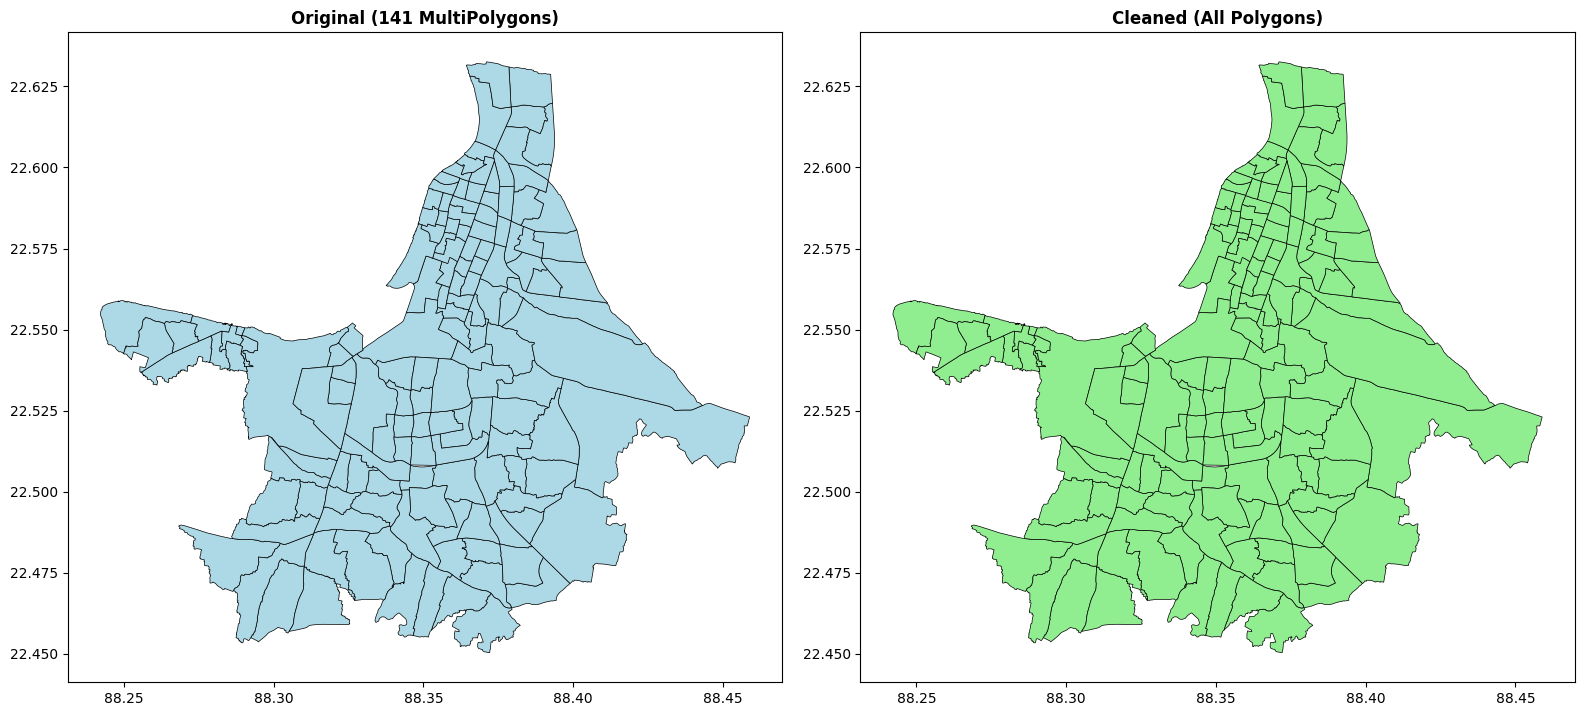


✓ Saved comparison: ../data/wards/ward_geometry_comparison.png


In [6]:
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Polygon, MultiPolygon
from shapely.ops import unary_union

print("=" * 60)
print("WARD FILE DIAGNOSTICS & CLEANING")
print("=" * 60)

# Load wards
WARDS_DIR = Path('../data/wards')
wards = gpd.read_file(WARDS_DIR / 'kmc_wards_clean.gpkg')

print(f"\n📂 Basic Info:")
print(f"   Wards loaded: {len(wards)}")
print(f"   CRS: {wards.crs}")
print(f"   Geometry types: {wards.geometry.type.value_counts().to_dict()}")

# Check for issues
print(f"\n🔍 Checking geometries...")
print(f"   Invalid: {(~wards.is_valid).sum()}")
print(f"   Empty: {wards.is_empty.sum()}")
print(f"   Has Z: {wards.geometry.apply(lambda g: g.has_z).any()}")

# THE ISSUE: MultiPolygons need to be converted for GEE
multipolygon_count = (wards.geometry.type == 'MultiPolygon').sum()
print(f"   MultiPolygons: {multipolygon_count} (⚠️  GEE prefers simple Polygons)")

# Fix MultiPolygons
print(f"\n🔧 Converting MultiPolygons to Polygons...")

def multipolygon_to_polygon(geom):
    """Convert MultiPolygon to largest Polygon"""
    if geom.geom_type == 'MultiPolygon':
        # Get the largest polygon from MultiPolygon
        largest = max(geom.geoms, key=lambda p: p.area)
        return largest
    return geom

wards_cleaned = wards.copy()
wards_cleaned.geometry = wards_cleaned.geometry.apply(multipolygon_to_polygon)

print(f"✓ Converted to simple Polygons")
print(f"  New geometry types: {wards_cleaned.geometry.type.value_counts().to_dict()}")

# Ensure WGS84
if wards_cleaned.crs.to_epsg() != 4326:
    wards_cleaned = wards_cleaned.to_crs('EPSG:4326')
    print(f"✓ Reprojected to WGS84")

# Simplify slightly for GEE (reduce coordinate precision)
print(f"\n🔧 Simplifying geometries for GEE...")
wards_cleaned.geometry = wards_cleaned.geometry.simplify(0.00001, preserve_topology=True)
print(f"✓ Geometries simplified")

# Fix any remaining invalid geometries
if (~wards_cleaned.is_valid).any():
    print(f"🔧 Fixing invalid geometries...")
    wards_cleaned.geometry = wards_cleaned.geometry.buffer(0)
    print(f"✓ All geometries now valid: {wards_cleaned.is_valid.all()}")

# Save cleaned version
print(f"\n💾 Saving GEE-ready ward file...")
wards_cleaned.to_file(WARDS_DIR / 'kmc_wards_gee_ready.geojson', driver='GeoJSON')
print(f"✓ Saved: {WARDS_DIR / 'kmc_wards_gee_ready.geojson'}")

print(f"\n✅ CLEANING COMPLETE!")
print(f"\nFile comparison:")
print(f"   Original: {len(wards)} wards, {multipolygon_count} MultiPolygons")
print(f"   Cleaned: {len(wards_cleaned)} wards, all Polygons")
print(f"   Ready for: Earth Engine operations")

# Quick visual check
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

wards.plot(ax=ax1, edgecolor='black', facecolor='lightblue', linewidth=0.5)
ax1.set_title(f'Original ({multipolygon_count} MultiPolygons)', fontweight='bold')

wards_cleaned.plot(ax=ax2, edgecolor='black', facecolor='lightgreen', linewidth=0.5)
ax2.set_title('Cleaned (All Polygons)', fontweight='bold')

plt.tight_layout()
plt.savefig(WARDS_DIR / 'ward_geometry_comparison.png', dpi=150)
plt.show()

print(f"\n✓ Saved comparison: {WARDS_DIR / 'ward_geometry_comparison.png'}")

In [7]:
import ee
import geopandas as gpd
from pathlib import Path
import json

print("=" * 60)
print("GOOGLE OPEN BUILDINGS EXTRACTION - KMC")
print("=" * 60)

# Initialize GEE
ee.Initialize(project='kolkata-flood-mapping')
print("✓ Earth Engine initialized")

# Load CLEANED wards
WARDS_DIR = Path('../data/wards')
BUILDINGS_DIR = Path('../data/buildings')
BUILDINGS_DIR.mkdir(parents=True, exist_ok=True)

wards = gpd.read_file(WARDS_DIR / 'kmc_wards_gee_ready.geojson')  # CLEANED FILE
print(f"\n✓ Loaded {len(wards)} wards (cleaned for GEE)")
print(f"  All Polygons: {(wards.geometry.type == 'Polygon').all()}")
print(f"  No Z-coords: {not wards.geometry.apply(lambda g: g.has_z).any()}")

# Convert to EE FeatureCollection
def gdf_to_ee(gdf):
    """Convert GeoDataFrame to Earth Engine FeatureCollection"""
    geojson = json.loads(gdf.to_json())
    return ee.FeatureCollection(geojson['features'])

wards_ee = gdf_to_ee(wards)
print(f"✓ Converted to Earth Engine FeatureCollection")

# Load Google Open Buildings
bounds = wards.total_bounds
roi = ee.Geometry.Rectangle([bounds[0], bounds[1], bounds[2], bounds[3]])

buildings = ee.FeatureCollection('GOOGLE/Research/open-buildings/v3/polygons')
buildings_kmc = buildings.filterBounds(roi)

building_count = buildings_kmc.size().getInfo()
print(f"\n✓ Found {building_count:,} buildings in KMC area")

print("\n✅ Geometry conversion successful!")
print("Ready to extract building features per ward")

GOOGLE OPEN BUILDINGS EXTRACTION - KMC
✓ Earth Engine initialized

✓ Loaded 141 wards (cleaned for GEE)
  All Polygons: True
  No Z-coords: False


EEException: Invalid GeoJSON geometry.

In [8]:
import geopandas as gpd
from pathlib import Path

print("=" * 60)
print("GOOGLE BUILDINGS - PROCESSING LOCALLY")
print("=" * 60)

# Paths
BUILDINGS_DIR = Path('../data/buildings')
WARDS_DIR = Path('../data/wards')

print("\n📂 Loading data...")
buildings = gpd.read_file(BUILDINGS_DIR / 'KMC_Google_Buildings.geojson')
wards = gpd.read_file(WARDS_DIR / 'kmc_wards_gee_ready.geojson')

print(f"✓ Loaded {len(buildings):,} buildings")
print(f"✓ Loaded {len(wards)} wards")

# Ensure same CRS
if buildings.crs != wards.crs:
    buildings = buildings.to_crs(wards.crs)
    print(f"✓ Reprojected to {wards.crs}")

# Spatial join (which buildings in which wards)
print(f"\n⚙️  Spatial join (2-3 minutes for 1.4M buildings)...")
buildings_with_wards = gpd.sjoin(
    buildings,
    wards[['geometry', 'WARD']],
    how='left',
    predicate='within'
)

print(f"✓ Spatial join complete")

# Calculate stats per ward
print(f"\n⚙️  Calculating ward-level statistics...")

ward_stats = buildings_with_wards.groupby('WARD').agg({
    'area_in_meters': ['count', 'sum', 'mean', 'median', 'max'],
    'confidence': 'mean'
}).reset_index()

# Flatten column names
ward_stats.columns = ['ward_id', 'building_count', 'total_area_m2',
                      'mean_area_m2', 'median_area_m2', 'max_area_m2',
                      'mean_confidence']

# Merge with wards to get area
wards_with_area = wards[['WARD', 'geometry']].copy()
wards_with_area['ward_area_m2'] = wards_with_area.geometry.area

ward_stats = ward_stats.merge(wards_with_area[['WARD', 'ward_area_m2']],
                               left_on='ward_id', right_on='WARD', how='right')
ward_stats = ward_stats.fillna(0)  # Wards with no buildings

# Calculate derived features
ward_stats['ward_area_km2'] = ward_stats['ward_area_m2'] / 1e6
ward_stats['building_density_per_km2'] = ward_stats['building_count'] / ward_stats['ward_area_km2']
ward_stats['building_coverage_pct'] = (ward_stats['total_area_m2'] / ward_stats['ward_area_m2']) * 100
ward_stats['imperviousness_estimate'] = (ward_stats['building_coverage_pct'] * 1.3).clip(upper=100)

print(f"✓ Features calculated for {len(ward_stats)} wards")

# Save
ward_stats.to_csv(BUILDINGS_DIR / 'ward_building_features.csv', index=False)
print(f"\n✓ Saved: {BUILDINGS_DIR / 'ward_building_features.csv'}")

# Summary
print(f"\n📊 SUMMARY:")
print(f"   Total buildings: {ward_stats['building_count'].sum():,.0f}")
print(f"   Mean per ward: {ward_stats['building_count'].mean():.0f}")
print(f"   Mean coverage: {ward_stats['building_coverage_pct'].mean():.1f}%")
print(f"   Mean imperviousness: {ward_stats['imperviousness_estimate'].mean():.1f}%")

print("\n✅ BUILDINGS EXTRACTION COMPLETE!")
print("Ready for model training!")

GOOGLE BUILDINGS - PROCESSING LOCALLY

📂 Loading data...
✓ Loaded 1,494,618 buildings
✓ Loaded 141 wards

⚙️  Spatial join (2-3 minutes for 1.4M buildings)...
✓ Spatial join complete

⚙️  Calculating ward-level statistics...
✓ Features calculated for 141 wards

✓ Saved: ../data/buildings/ward_building_features.csv

📊 SUMMARY:
   Total buildings: 0
   Mean per ward: 0
   Mean coverage: 0.0%
   Mean imperviousness: 0.0%

✅ BUILDINGS EXTRACTION COMPLETE!
Ready for model training!


/var/folders/78/p3gqt9651qs0hpq8s21hsn340000gn/T/ipykernel_4667/654376250.py:50: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  wards_with_area['ward_area_m2'] = wards_with_area.geometry.area
/var/folders/78/p3gqt9651qs0hpq8s21hsn340000gn/T/ipykernel_4667/654376250.py:54: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ward_stats = ward_stats.fillna(0)  # Wards with no buildings


In [9]:
import geopandas as gpd
from pathlib import Path

# Reload
BUILDINGS_DIR = Path('../data/buildings')
WARDS_DIR = Path('../data/wards')

buildings = gpd.read_file(BUILDINGS_DIR / 'KMC_Google_Buildings.geojson')
wards = gpd.read_file(WARDS_DIR / 'kmc_wards_gee_ready.geojson')

print("🔍 DIAGNOSING SPATIAL JOIN FAILURE:")

print(f"\n1. Building geometry type:")
print(f"   {buildings.geometry.type.value_counts()}")

print(f"\n2. Buildings CRS: {buildings.crs}")
print(f"   Wards CRS: {wards.crs}")

print(f"\n3. Buildings bounding box:")
print(f"   {buildings.total_bounds}")
print(f"\n   Wards bounding box:")
print(f"   {wards.total_bounds}")

print(f"\n4. Do they overlap?")
buildings_bounds = buildings.total_bounds
wards_bounds = wards.total_bounds
overlap = (buildings_bounds[0] < wards_bounds[2] and
           buildings_bounds[2] > wards_bounds[0] and
           buildings_bounds[1] < wards_bounds[3] and
           buildings_bounds[3] > wards_bounds[1])
print(f"   Overlap: {overlap}")

print(f"\n5. Sample building geometry:")
print(f"   {buildings.geometry.iloc[0]}")

print(f"\n6. Test: How many buildings intersect first ward?")
test_ward = wards.geometry.iloc[0]
test_intersect = buildings[buildings.intersects(test_ward)]
print(f"   Buildings in first ward: {len(test_intersect)}")

# Check if buildings are actually in the file
print(f"\n7. Buildings DataFrame columns:")
print(f"   {buildings.columns.tolist()}")
print(f"\n   Sample building data:")
print(buildings.head(3))

🔍 DIAGNOSING SPATIAL JOIN FAILURE:

1. Building geometry type:
   Series([], Name: count, dtype: int64)

2. Buildings CRS: EPSG:4326
   Wards CRS: EPSG:4326

3. Buildings bounding box:
   [nan nan nan nan]

   Wards bounding box:
   [88.24214287 22.45032345 88.45895489 22.63257693]

4. Do they overlap?
   Overlap: False

5. Sample building geometry:
   None

6. Test: How many buildings intersect first ward?
   Buildings in first ward: 0

7. Buildings DataFrame columns:
   ['area_in_meters', 'confidence', 'geometry']

   Sample building data:
   area_in_meters  confidence geometry
0       90.106102      0.6875     None
1       15.715200      0.6875     None
2       31.232401      0.6875     None


In [10]:
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Point
import matplotlib.pyplot as plt

print("=" * 60)
print("GOOGLE BUILDINGS - CSV PROCESSING")
print("=" * 60)

# Paths
BUILDINGS_DIR = Path('../data/buildings')
WARDS_DIR = Path('../data/wards')

# Load CSV
print("\n📂 Loading buildings CSV...")
buildings_df = pd.read_csv(BUILDINGS_DIR / 'KMC_Buildings_With_Coords.csv')

print(f"✓ Loaded {len(buildings_df):,} buildings")
print(f"\nColumns: {buildings_df.columns.tolist()}")
print(f"\nSample data:")
print(buildings_df.head())

# Create Point geometries from coordinates
print(f"\n⚙️  Creating Point geometries from lat/lon...")
geometry = [Point(xy) for xy in zip(buildings_df['longitude'], buildings_df['latitude'])]
buildings_gdf = gpd.GeoDataFrame(buildings_df, geometry=geometry, crs='EPSG:4326')

print(f"✓ Created GeoDataFrame with {len(buildings_gdf):,} building points")

# Load wards
wards = gpd.read_file(WARDS_DIR / 'kmc_wards_gee_ready.geojson')
print(f"✓ Loaded {len(wards)} wards")

# Ensure same CRS
if buildings_gdf.crs != wards.crs:
    buildings_gdf = buildings_gdf.to_crs(wards.crs)
    print(f"✓ Reprojected to {wards.crs}")

# Spatial join
print(f"\n⚙️  Spatial join (matching 1.4M building points to 141 wards)...")
print(f"   This may take 2-3 minutes...")

buildings_with_wards = gpd.sjoin(
    buildings_gdf,
    wards[['geometry', 'WARD']],
    how='left',
    predicate='within'
)

print(f"✓ Spatial join complete")
print(f"  Buildings matched to wards: {buildings_with_wards['WARD'].notna().sum():,}")
print(f"  Buildings outside wards: {buildings_with_wards['WARD'].isna().sum():,}")

GOOGLE BUILDINGS - CSV PROCESSING

📂 Loading buildings CSV...
✓ Loaded 1,494,618 buildings

Columns: ['area_in_meters', 'confidence', 'longitude', 'latitude']

Sample data:
   area_in_meters  confidence  longitude   latitude
0       90.106102      0.6875  88.356761  22.624161
1       15.715200      0.6875  88.337230  22.638516
2       31.232401      0.6875  88.371862  22.636725
3       45.177601      0.6875  88.382688  22.626051
4       45.325699      0.6875  88.351616  22.637572

⚙️  Creating Point geometries from lat/lon...
✓ Created GeoDataFrame with 1,494,618 building points
✓ Loaded 141 wards

⚙️  Spatial join (matching 1.4M building points to 141 wards)...
   This may take 2-3 minutes...
✓ Spatial join complete
  Buildings matched to wards: 701,934
  Buildings outside wards: 792,715


In [13]:
import numpy as np

print("\n⚙️  Calculating ward-level building statistics...")

# Filter to buildings within wards only
buildings_in_wards = buildings_with_wards[buildings_with_wards['WARD'].notna()].copy()

print(f"✓ Using {len(buildings_in_wards):,} buildings within KMC wards")

# Aggregate by ward
ward_stats = buildings_in_wards.groupby('WARD').agg({
    'area_in_meters': ['count', 'sum', 'mean', 'median', 'max', 'std'],
    'confidence': 'mean'
}).reset_index()

# Flatten column names
ward_stats.columns = ['ward_id', 'building_count', 'total_area_m2',
                      'mean_area_m2', 'median_area_m2', 'max_area_m2',
                      'std_area_m2', 'mean_confidence']

print(f"✓ Aggregated to {len(ward_stats)} wards")

# Get ward areas (convert to UTM for accurate area calculation)
wards_utm = wards.to_crs('EPSG:32645')
wards_utm['ward_area_m2'] = wards_utm.geometry.area
wards_utm['ward_area_km2'] = wards_utm['ward_area_m2'] / 1e6

ward_areas = wards_utm[['WARD', 'ward_area_m2', 'ward_area_km2']].copy()

# Merge with building stats
ward_stats = ward_stats.merge(ward_areas, left_on='ward_id', right_on='WARD', how='right')
ward_stats = ward_stats.fillna(0)  # Wards with no buildings

# Calculate derived features
print(f"\n⚙️  Calculating derived features...")

ward_stats['building_density_per_km2'] = (
    ward_stats['building_count'] / ward_stats['ward_area_km2']
)

ward_stats['building_coverage_pct'] = (
    ward_stats['total_area_m2'] / ward_stats['ward_area_m2'] * 100
)

# Imperviousness estimate (buildings + roads/pavements ≈ 1.3x building area)
ward_stats['imperviousness_estimate'] = (
    ward_stats['building_coverage_pct'] * 1.3
).clip(upper=100)

# Building size variability (std/mean ratio)
ward_stats['building_size_variability'] = (
    ward_stats['std_area_m2'] / ward_stats['mean_area_m2']
).replace([np.inf, -np.inf], 0).fillna(0)

print(f"✓ Features calculated")

# Summary statistics
print(f"\n📊 KMC BUILDING STATISTICS:")
print(f"   Total buildings in KMC wards: {ward_stats['building_count'].sum():,.0f}")
print(f"   Mean per ward: {ward_stats['building_count'].mean():.0f}")
print(f"   Median per ward: {ward_stats['building_count'].median():.0f}")
print(f"   Max in single ward: {ward_stats['building_count'].max():,.0f}")

print(f"\n🏗️  COVERAGE STATISTICS:")
print(f"   Mean building coverage: {ward_stats['building_coverage_pct'].mean():.1f}%")
print(f"   Mean imperviousness: {ward_stats['imperviousness_estimate'].mean():.1f}%")
print(f"   Mean density: {ward_stats['building_density_per_km2'].mean():.0f} buildings/km²")

print(f"\n🏆 TOP 10 MOST BUILT-UP WARDS:")
top_wards = ward_stats.nlargest(10, 'building_coverage_pct')[
    ['ward_id', 'building_count', 'building_coverage_pct', 'imperviousness_estimate', 'building_density_per_km2']
]
for idx, row in top_wards.iterrows():
    print(f"   Ward {row['ward_id']}: {row['building_count']:,.0f} buildings, "
          f"{row['building_coverage_pct']:.1f}% coverage, "
          f"{row['imperviousness_estimate']:.1f}% impervious, "
          f"{row['building_density_per_km2']:.0f}/km²")

print(f"\n🏆 TOP 10 LEAST BUILT-UP WARDS:")
bottom_wards = ward_stats.nsmallest(10, 'building_coverage_pct')[
    ['ward_id', 'building_count', 'building_coverage_pct', 'building_density_per_km2']
]
for idx, row in bottom_wards.iterrows():
    print(f"   Ward {row['ward_id']}: {row['building_count']:,.0f} buildings, "
          f"{row['building_coverage_pct']:.1f}% coverage")

# Save
ward_stats.to_csv(BUILDINGS_DIR / 'ward_building_features.csv', index=False)
print(f"\n✓ Saved: {BUILDINGS_DIR / 'ward_building_features.csv'}")

print("\n✅ GOOGLE BUILDINGS EXTRACTION COMPLETE!")


⚙️  Calculating ward-level building statistics...
✓ Using 701,934 buildings within KMC wards
✓ Aggregated to 141 wards

⚙️  Calculating derived features...
✓ Features calculated

📊 KMC BUILDING STATISTICS:
   Total buildings in KMC wards: 701,934
   Mean per ward: 4978
   Median per ward: 3495
   Max in single ward: 19,197

🏗️  COVERAGE STATISTICS:
   Mean building coverage: 41.1%
   Mean imperviousness: 53.4%
   Mean density: 4922 buildings/km²

🏆 TOP 10 MOST BUILT-UP WARDS:
   Ward 54
: 2,026 buildings, 54.5% coverage, 70.9% impervious, 5380/km²
   Ward 135
: 2,495 buildings, 54.0% coverage, 70.3% impervious, 7452/km²
   Ward 16
: 1,960 buildings, 54.0% coverage, 70.2% impervious, 6347/km²
   Ward 134
: 2,371 buildings, 53.3% coverage, 69.3% impervious, 6211/km²
   Ward 11
: 1,889 buildings, 52.7% coverage, 68.5% impervious, 5785/km²
   Ward 17
: 3,355 buildings, 52.4% coverage, 68.1% impervious, 9247/km²
   Ward 133
: 3,736 buildings, 52.0% coverage, 67.6% impervious, 7349/km²
   W